# Purpose

The purpose of this notebook is to build a ANN multi-classification PyTorch model for the Iris Flower dataset.  This notebook will dempnstrate:
* Splitting data for train and test sets
* Converting numpy data to PyTorch tensor data
* Building a class
* Elementary tuning
* Evaluatung model and displaying the results

The Iris Flower ANN_Classifier model class will have the following methods: 
* forward() 
* predict() 
* score() 
* plot_losses() 
* plot_training_accuracy()
* confusion_matrix()

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# DATA
* Loading data
* Encoding
* Train Test Split
* Changing dtypes

**LOADING DATA**

In [2]:
iris = sns.load_dataset('iris')
# iris.head()

In [3]:
iris.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

**ENCODING TARGET VARIABLE**

In [4]:
iris.species = np.where(iris.species == 'setosa', 0, np.where(iris.species == 'versicolor', 1, 2))
# iris.species

In [5]:
# iris.columns[0:4].values
# iris[iris.columns[0:4]].values

**SPLITTING X AND y VARIABLES**

In [6]:
# FUNCTION TO INDEX COLUMNS

def X_y(data, X_col_index_start, X_col_index_end, y_col_index_start, y_col_index_end):
    
    X = data[data.columns[X_col_index_start:X_col_index_end]].values
    y = np.ravel(data[data.columns[y_col_index_start:y_col_index_end]].values)
    
    return X,y

In [7]:
X, y = X_y(iris, X_col_index_start=0, X_col_index_end=4, y_col_index_start=4, y_col_index_end=None)

**TRAIN TEST SPLIT**

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# TRAIN TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

**CONVERTING FROM NUMPY ARRAY TO PYTORCH TENSOR**

In [10]:
# FUNCTION FOR CONVERTING TRAIN AND TEST SETS INTO TENSORS

def convert_tensor(X,y):
    
    X = torch.tensor(X, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)
    
    return X,y

In [11]:
# CONVERTING TO TENSORS

X_train,y_train = convert_tensor(X_train,y_train)
X_test, y_test = convert_tensor(X_test, y_test)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(120, 30, 120, 30)

# MODEL CLASS

In [13]:
# IRIS DATASET ANN MODEL

class ANN_Classifier(nn.Module):
    
    def __init__(self, lr=0.1, epochs=500, units_per_layer=20, rand_seed=None):
        super().__init__()
        self.lr = lr # learning rate
        self.epochs = epochs # training epochs
        self.units_per_layer = units_per_layer
        self.rand_seed = rand_seed;
        
    def forward(self,X,y):
        if self.rand_seed is not None:
            torch.manual_seed(self.rand_seed)
        self.X = X # features
        self.y = y # target
        
        
        #### model architecture ###
        self.ANN_clf = nn.Sequential(
            nn.Linear(self.X.size()[1],self.units_per_layer), # input layer, i
            nn.ReLU(), # non-linear activation function
            nn.Linear(self.units_per_layer,self.units_per_layer), # hidden layer, h1
            nn.ReLU(), # non-linear activation function
            nn.Linear(self.units_per_layer,3), # output layer, y
            # nn.Softmax(dim=1)
        )
        
        loss_fu = nn.CrossEntropyLoss() # loss function (combination of torch.nn.LogSoftmax and torch.nn.NLLLoss)
        opti = torch.optim.SGD(self.ANN_clf.parameters(), self.lr) # optimizer
        
        self.losses = torch.zeros(self.epochs) # blank list of losses
        self.train_accuracy = torch.zeros(self.epochs) # blank list of accuracies
        self.ANN_clf.train() # setting training mode
        
        for epoch in range(self.epochs):
            pred = self.ANN_clf(self.X) # predictions forward pass
            loss = loss_fu(pred,self.y) # computing loss
            self.losses[epoch] = loss # storing loss
            
            opti.zero_grad() # zeroing gradients
            loss.backward() # backprop
            opti.step() # updating weights and bias
            
            # Accuracy per epoch
            # assigning the label to the highest probability and comparing it to the true labels
            matches = (torch.argmax(pred,axis=1) == self.y).float()
            acc_percentage = 100*torch.mean(matches)
            self.train_accuracy[epoch] = acc_percentage
        ;
    def predict(self, X, proba=False):
        if self.rand_seed is not None:
            torch.manual_seed(self.rand_seed)
        self.ANN_clf.eval()
        with torch.no_grad():
            y_pred_probs = self.ANN_clf(X) # predictions
            # assigning the label to the highest probability
            y_pred_labels = torch.argmax(y_pred_probs, axis=1)
            if proba == False:
                return y_pred_labels
            if proba == True:
                sm = nn.Softmax(dim=1) # scale the probs between 0 and 1
                return y_pred_labels, sm(y_pred_probs)
        ;      
    
    def score(self,X,y):
        if self.rand_seed is not None:
            torch.manual_seed(self.rand_seed)
        self.ANN_clf.eval()
        with torch.no_grad():
            y_pred_probs = self.ANN_clf(X) # predictions
            # assigning the label to the highest probability
            y_pred_labels = torch.argmax(y_pred_probs, axis=1)
            matches = (y_pred_labels == y).float()
            self.accuracy_ = 100*torch.mean(matches)
            return self.accuracy_
        ;
    
    def plot_losses(self, label='Losses'): # plotting losses over training epochs
        plt.plot(range(self.epochs), self.losses.detach().numpy(), label=label)
        plt.axhline(self.losses[-1].detach().numpy(), c='r', ls=':')
        plt.axvline(self.epochs, c='r', ls=':')
        plt.grid()
        plt.legend()
        plt.title('Losses per Epoch');
        
    def plot_train_accuracy(self, label='Accuracy'): # plotting accuracy over training epochs
        plt.plot(range(self.epochs), self.train_accuracy.detach().numpy(), label=label)
        plt.axhline(self.train_accuracy[-1].detach().numpy(), c='r', ls=':')
        plt.axvline(self.epochs, c='r', ls=':')
        plt.grid()
        plt.legend()
        plt.title('Accuracy per Epoch');
        
    def confusion_matrix(self, y_test, y_preds, labels=None):
        cm = confusion_matrix(y_test.numpy(), y_preds.numpy())
        if labels is not None:
            sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels);
        else:
            sns.heatmap(cm, annot=True, cmap='Blues');

# TUNING MODEL
* Learning rate 
* Layer unit size

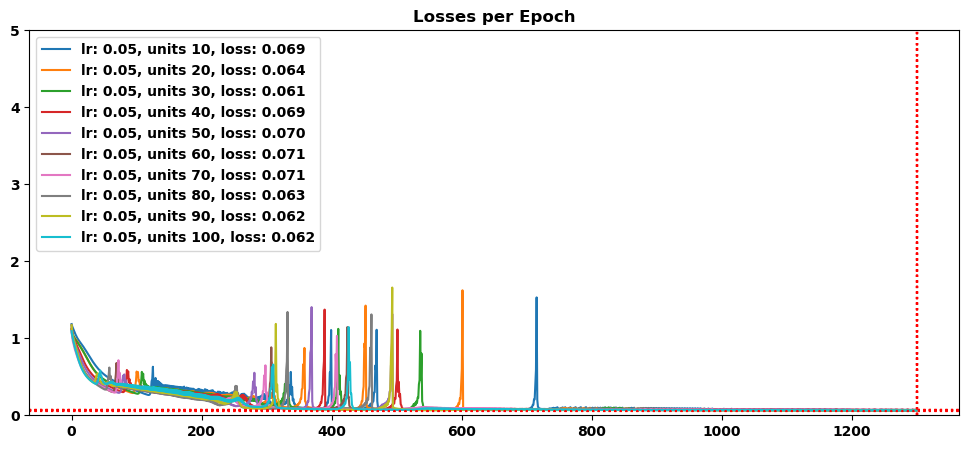

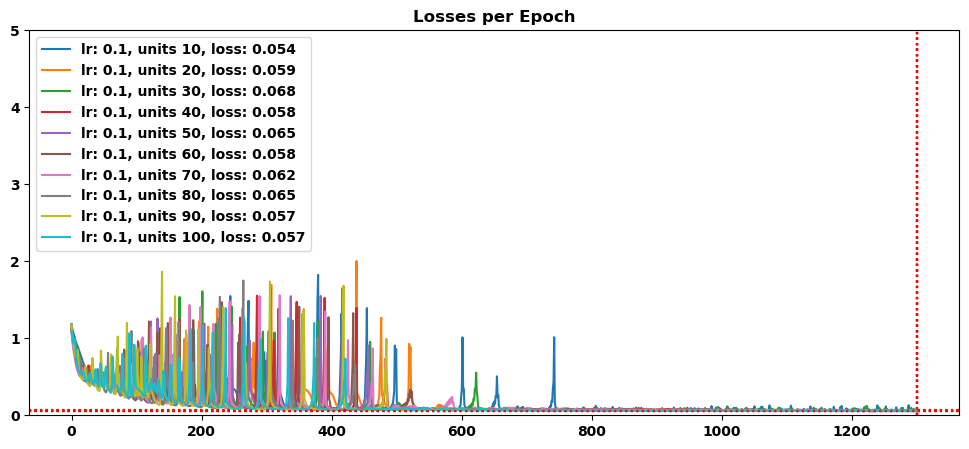

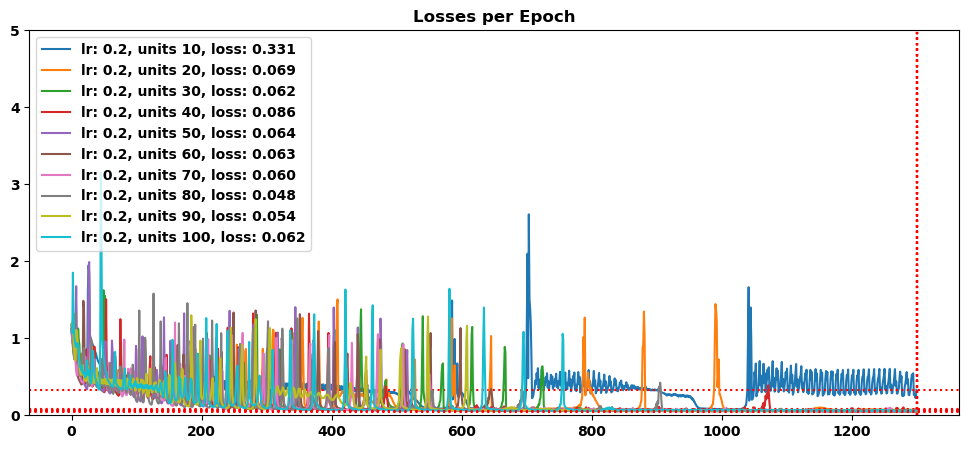

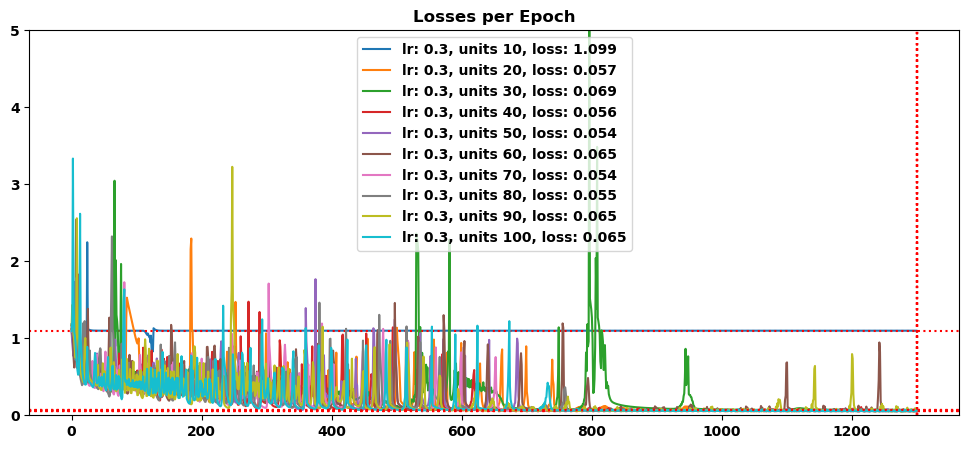

In [14]:
# CHECKING LEARNING RATES AND LAYER UNIT SIZE

lr_list = [0.05,0.1,0.2,0.3]
units_per = [10,20,30,40,50,60,70]

for lr in lr_list:
    plt.figure(figsize=(12,5))
    for units in units_per:
        clf = ANN_Classifier(lr=lr, epochs=1300, units_per_layer=units, rand_seed=5)
        clf.forward(X_train,y_train)
        clf.plot_losses(label=f'lr: {lr}, ' f'units {units}, ' f'loss: {clf.losses[-1].item():.3f}')
        plt.ylim(bottom=0, top=5)
    plt.show()

# FITTING MODEL, PLOTTING LOSSES & ACCURACIES, AND PREDICTING
* Learning Rate = 0.1
* Units per Layer = 40
* Epoch = 1000

**FITTING FINAL MODEL AND PLOTTING LOSSES**

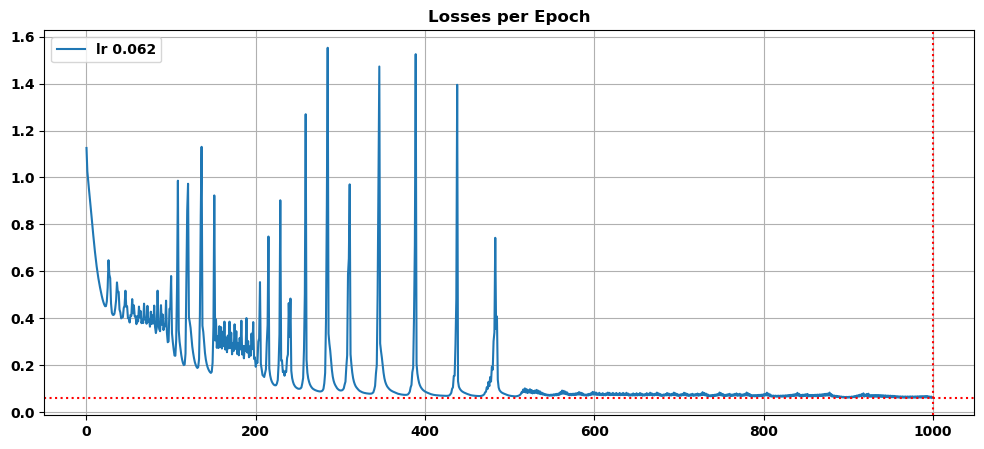

In [15]:
clf = ANN_Classifier(lr=0.1, epochs=1000, units_per_layer=40, rand_seed=5)
clf.forward(X_train,y_train)

plt.figure(figsize=(12,5))
clf.plot_losses(label=f'lr {clf.losses[-1].detach().item():.3f}')

**PLOTTING ACCURACY PER EPOCH**

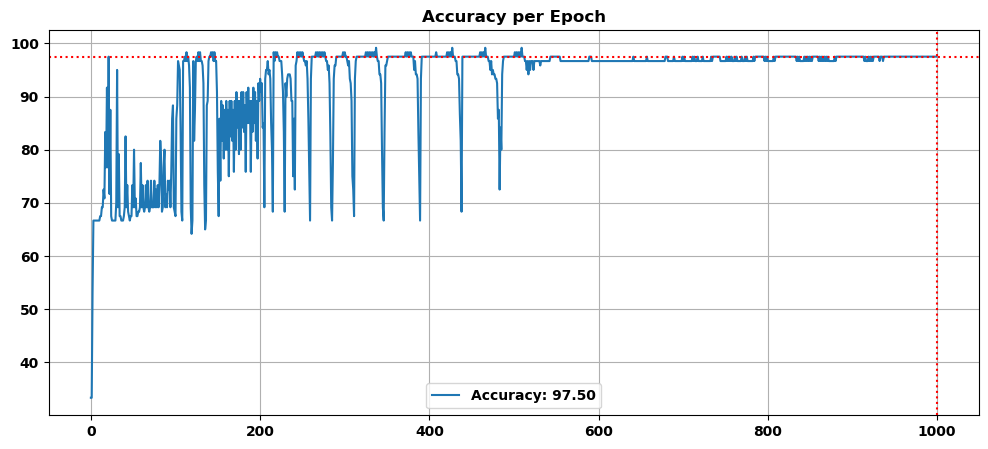

In [16]:
plt.figure(figsize=(12,5))
clf.plot_train_accuracy(label=f'Accuracy: {clf.train_accuracy[-1]:.2f}')

**PREDICTIONS AND PROBABILITIES**

In [17]:
# PREDICTIONS ON TEST SET

y_preds, y_probas = clf.predict(X_test, proba=True)
# y_preds

In [18]:
# y_probas

# EVAL
* Classification Report
* Confusion Matrix
* Training verse Testing Accuracy

**CLASSIFICATION REPORT**

In [19]:
print(classification_report(y_test.numpy(), y_preds.numpy()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



**CONFUSION MATRIX**

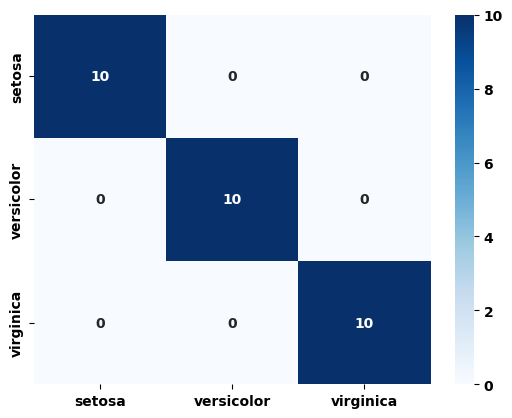

In [20]:
labels = ['setosa', 'versicolor', 'virginica']

clf.confusion_matrix(y_test=y_test, y_preds=y_preds, labels=labels)

**TRAINING ACCURACY VS TESTING ACCURACY**

In [21]:
print(f'Training Accuracy: {clf.score(X_train,y_train):.3f}')
print(f'Testing Accuracy: {clf.score(X_test,y_test):.3f}')

Training Accuracy: 97.500
Testing Accuracy: 100.000
